In [26]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
import tensorflow as tf
import pandas as pd
from sklearn.metrics import pairwise_distances

from collections import defaultdict

sns.set_context('talk')
%config InlineBackend.figure_format='retina'


In [27]:
color1 = '#6138ba'
color2 = 'pink'

BINS = np.arange(1, 12)
NUM_CLASSES = len(BINS)

EXPERIMENT_PARAMS = {
    'eps': 0.001,
    'n_samples': 100_000,
    'color': {'p': color1, 'q': color2}
}

In [28]:
class Distribution:

    def __init__(self, prob_dict: dict, eps=0.001):
        self.bins = BINS
        self.num_bins = len(self.bins)
        self.prob_dict = prob_dict
        self.eps = eps
        self.probs = self.prob_dict_to_array(self.prob_dict)

    def prob_dict_to_array(self, prob_dict):

        # Assert values are valid probability distribution
        assert np.isclose(sum(list(prob_dict.values())), 1, atol=0.0001)

        probs = np.zeros(self.num_bins)
        for bin_, p in prob_dict.items():
            probs[bin_ - 1] = p

        # Assert probs is valid distribution

        assert np.isclose(probs.sum(), 1, atol=0.0001)

        # Add a tiny amount of noise to replicate "label smoothing"
        if self.eps != 0:
            bins_with_zero_prob_mass = (probs == 0).sum()
            bins_with_nonzero_prob_mass = (probs != 0).sum()
            eps_remove_from_bins = self.eps / bins_with_nonzero_prob_mass
            eps_add_to_bins = self.eps / bins_with_zero_prob_mass
            probs = np.where(
                probs==0, 
                eps_add_to_bins, 
                probs - eps_remove_from_bins
            )

            # Assert probs is valid distribution
            assert np.isclose(probs.sum(), 1, atol=0.0001)

        return probs


    def sample(self, n_samples):
        # Sample the count of times each bin occurs
        return np.random.multinomial(n=n_samples, pvals=self.probs)


    def sample_ohe(self, n_samples):
        # Sample the count of times each bin occurs
        counts = self.sample(n_samples)

        # One hot encode
        l = []
        for i, x in enumerate(counts):
            l.extend([i] * x)
        one_hot_encoded_samples = keras.utils.to_categorical(l, num_classes=11)
        return one_hot_encoded_samples

    @classmethod
    def normalize_samples(cls, samples):
        return samples / samples.sum()

    @classmethod
    def normalize_one_hot_samples(cls, ohe_samples):
        ohe_samples_summed = ohe_samples.sum(axis=0)
        return ohe_samples_summed / ohe_samples_summed.sum()


def plot_distribution(p, color=color1):
    x = np.arange(1, len(p) + 1)
    plt.bar(x=x, height=p, alpha=0.5, label='p', color=color, edgecolor='black')
    plt.xticks(x)
    plt.xlabel('bin')
    plt.ylabel('Probability')
    plt.ylim(top=1.1)


def plot_distributions(distributions_list):

    # Currently only able to handle 4
    num_plots = len(distributions_list)
    assert num_plots <= 4

    fig, axs = plt.subplots(nrows=1, ncols=num_plots, figsize=(25, 4))

    for i, distribution_dict in enumerate(distributions_list):

        for name, distribution in distribution_dict.items():
            x = np.arange(1, len(distribution.probs) + 1)
            axs[i].bar(x=x, height=distribution.probs, alpha=0.5, label=name, color=EXPERIMENT_PARAMS['color'][name], edgecolor='black')

        axs[i].set_xticks(x)
        axs[i].set_ylim(top=1.1)
        axs[i].set_xlabel('Bin')
        axs[i].legend(fontsize=12)

        if i == 0:
            axs[i].set_ylabel('Probability')

        axs[i].set_title(f'#{i + 1}')

    plt.show()


### 1. Generate toy data set
Start with a single `x` input that is paired with a specific `p(y|x)` distribution. 

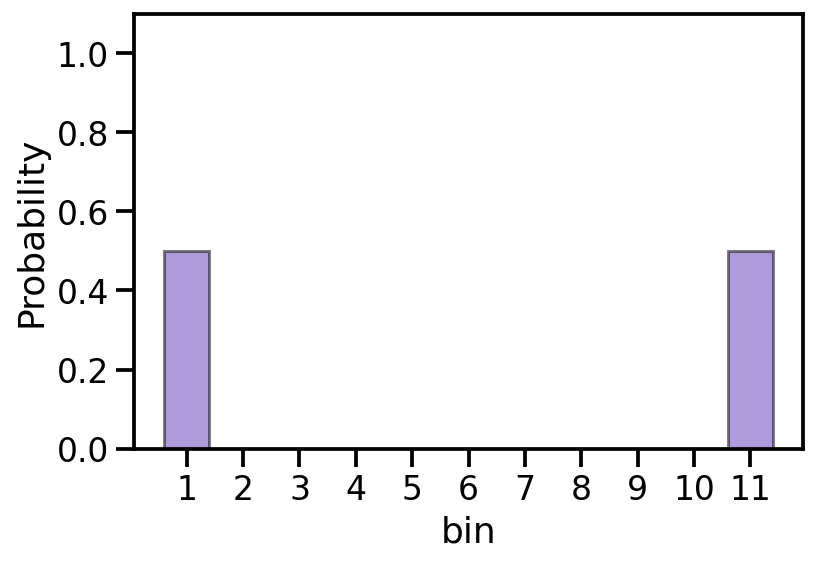

In [29]:
d1 = Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])

plot_distribution(d1.probs)

In [30]:
y1 = d1.sample_ohe(n_samples=EXPERIMENT_PARAMS['n_samples'])
y1.shape

(100000, 11)

In [31]:
x1 = np.zeros(shape=(y1.shape[0], 1))
x1.shape

(100000, 1)

In [32]:
def construct_model(loss='categorical_crossentropy'):
    model = keras.Sequential()

    model.add(
        keras.layers.Dense(
            units=NUM_CLASSES,
            activation='softmax',
            kernel_initializer=keras.initializers.RandomUniform(
                minval=-0.005,
                maxval=0.005,
            )
        )
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=loss,
        metrics=["categorical_crossentropy"],
    )

    return model



In [34]:
X = x1
y = y1

model = construct_model()

model.fit(
    X, 
    y, 
    epochs=5
)

Epoch 1/5
3125/3125 [==============================] - 1s 382us/step - loss: 1.2062 - categorical_crossentropy: 1.2062
Epoch 2/5
3125/3125 [==============================] - 1s 381us/step - loss: 0.7439 - categorical_crossentropy: 0.7439
Epoch 3/5
3125/3125 [==============================] - 1s 373us/step - loss: 0.7111 - categorical_crossentropy: 0.7111
Epoch 4/5
3125/3125 [==============================] - 1s 413us/step - loss: 0.7048 - categorical_crossentropy: 0.7048
Epoch 5/5
3125/3125 [==============================] - 1s 366us/step - loss: 0.7034 - categorical_crossentropy: 0.7034


In [35]:
y_pred = model.predict(X[0])

1/1 [==============================] - 0s 26ms/step


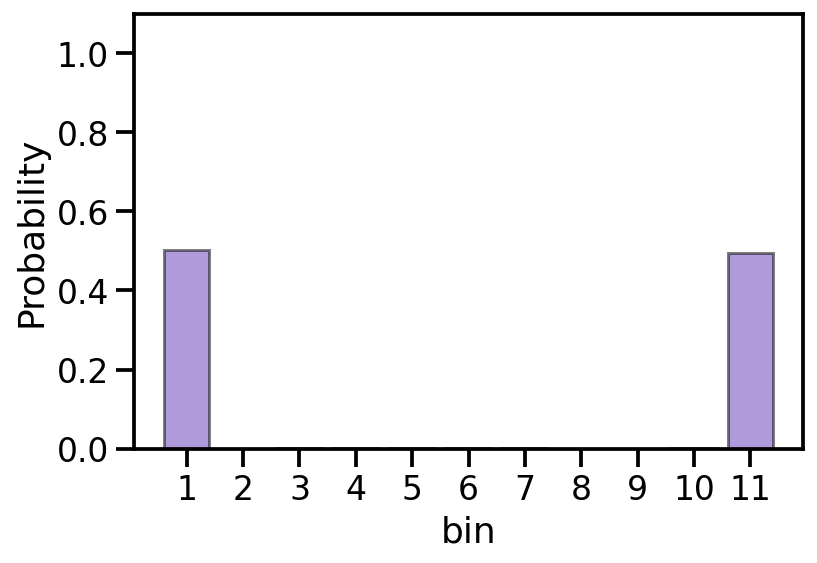

In [36]:
plot_distribution(y_pred[0])

In [15]:
# TODO: You need to come up with another example that might make learning the distribution below preferable 
# In other words: above, it was easier for cross entropy to learn the true ground truth distribution. But imagine that 
# we have a few other distributions that the model sees and has to confront. 
# What other examples could be present that would mean that we would want the model to need to learn the distribution below in 
# order to minimize?

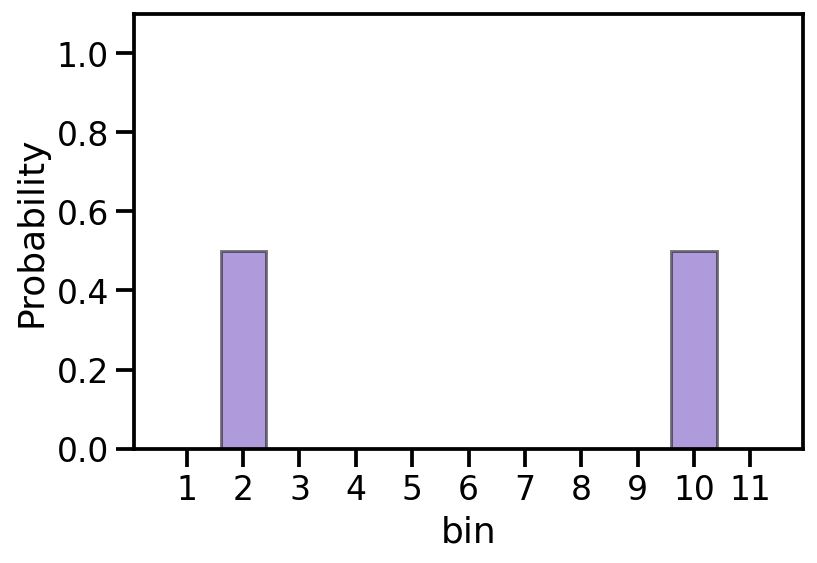

In [16]:
d2 = Distribution({2: 0.5, 10: 0.5}, eps=EXPERIMENT_PARAMS['eps'])

plot_distribution(d2.probs)

# Experiment 2

In [37]:
d1 = Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
d2 = Distribution({2: 0.5, 10: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
d3 = Distribution({1: 0.9, 11: 0.1}, eps=EXPERIMENT_PARAMS['eps'])
d4 = Distribution({i: 1 / 11 for i in np.arange(1, 12)}, eps=0)

In [38]:
y1 = d1.sample_ohe(n_samples=EXPERIMENT_PARAMS['n_samples'])
y2 = d2.sample_ohe(n_samples=EXPERIMENT_PARAMS['n_samples'])
y3 = d3.sample_ohe(n_samples=EXPERIMENT_PARAMS['n_samples'])
y4 = d4.sample_ohe(n_samples=EXPERIMENT_PARAMS['n_samples'])

x1 = np.zeros(shape=(y1.shape[0], 1)) 
x2 = np.zeros(shape=(y2.shape[0], 1)) + 1
x3 = np.zeros(shape=(y3.shape[0], 1)) - 1
x4 = np.zeros(shape=(y4.shape[0], 1)) + 2

In [39]:
X = np.vstack([x1, x2, x3, x4])

In [40]:
X = np.vstack([x1, x2, x3, x4])
y = np.vstack([y1, y2, y3, y4])

model = construct_model()

model.fit(
    X, 
    y, 
    epochs=10
)

Epoch 1/10
12500/12500 [==============================] - 5s 376us/step - loss: 1.4434 - categorical_crossentropy: 1.4434
Epoch 2/10
12500/12500 [==============================] - 5s 366us/step - loss: 1.3170 - categorical_crossentropy: 1.3170
Epoch 3/10
12500/12500 [==============================] - 5s 372us/step - loss: 1.3009 - categorical_crossentropy: 1.3009
Epoch 4/10
12500/12500 [==============================] - 5s 365us/step - loss: 1.2942 - categorical_crossentropy: 1.2942
Epoch 5/10
12500/12500 [==============================] - 5s 367us/step - loss: 1.2905 - categorical_crossentropy: 1.2905
Epoch 6/10
 7040/12500 [===============>..............] - ETA: 1s - loss: 1.2889 - categorical_crossentropy: 1.2889

1/1 [==============================] - 0s 11ms/step


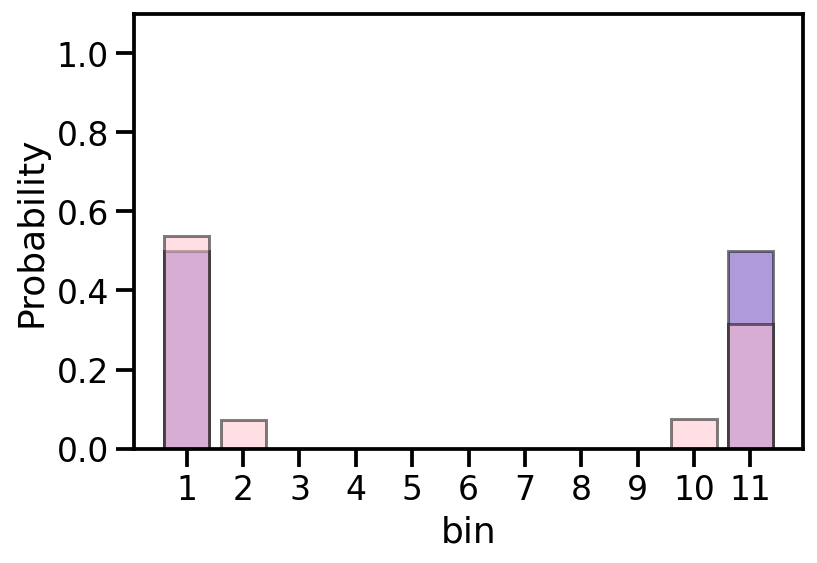

In [ ]:
plot_distribution(d1.probs)

y_pred1 = model.predict(x1[0])
plot_distribution(y_pred1[0], color=color2)

1/1 [==============================] - 0s 9ms/step


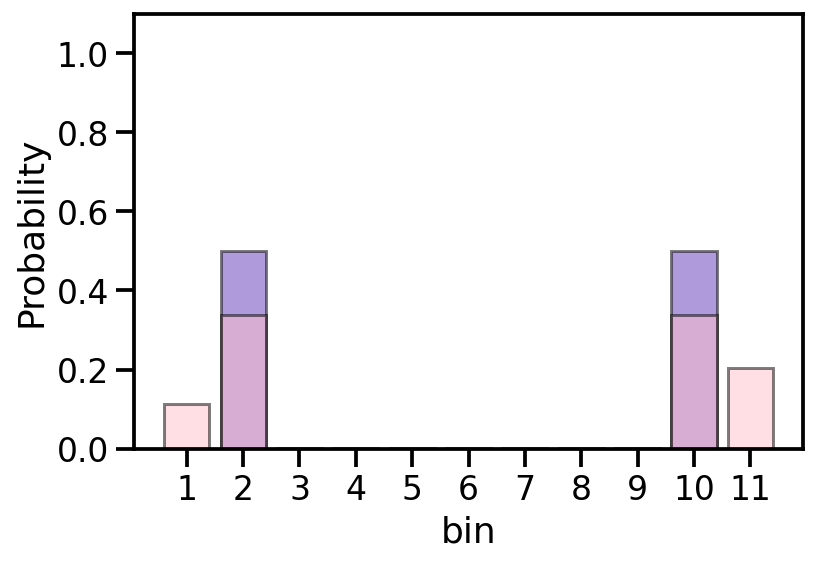

In [23]:
plot_distribution(d2.probs)

y_pred2 = model.predict(x2[0])
plot_distribution(y_pred2[0], color=color2)

1/1 [==============================] - 0s 12ms/step


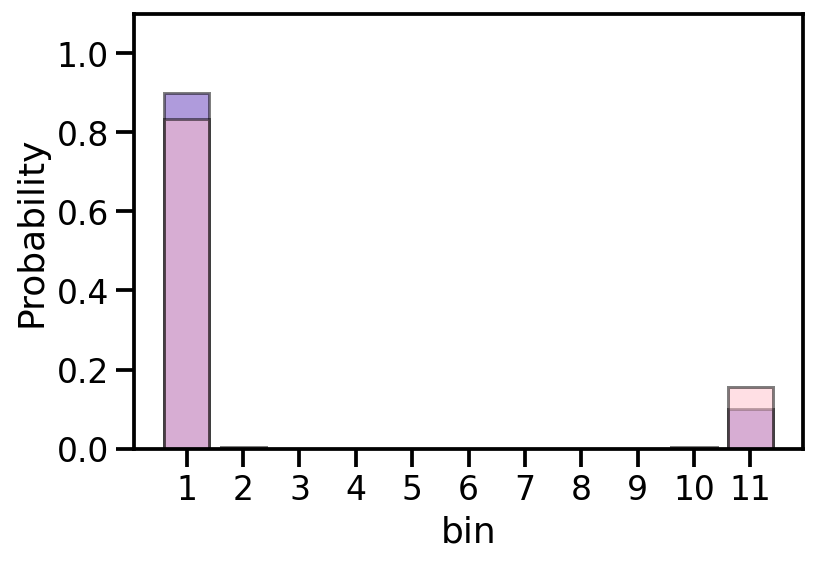

In [24]:
plot_distribution(d3.probs)

y_pred3 = model.predict(x3[0])
plot_distribution(y_pred3[0], color=color2)

1/1 [==============================] - 0s 12ms/step


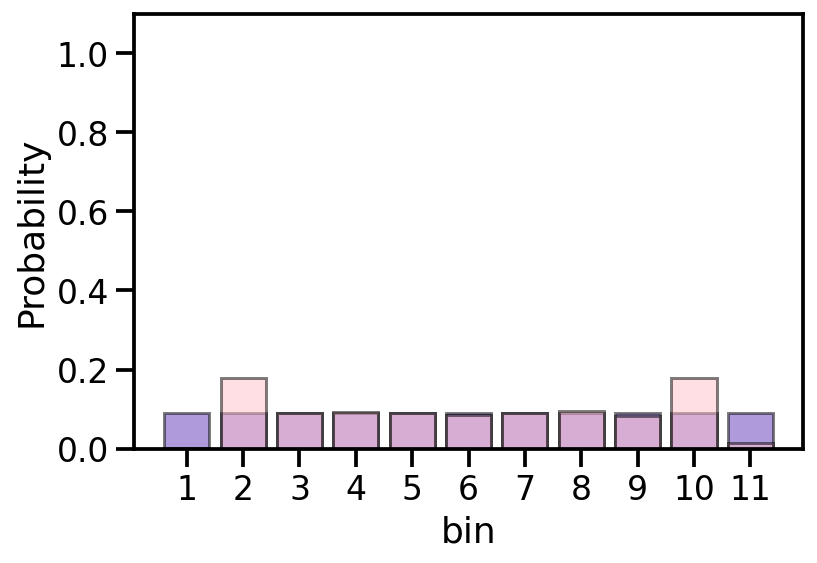

In [25]:
plot_distribution(d4.probs)

y_pred4 = model.predict(x4[0])
plot_distribution(y_pred4[0], color=color2)

# Experiment 2: Custom Loss Function

In [67]:
from functools import partial

In [69]:
def gaussian_kernel(x, y, std=1):
    dist = np.abs(x - y)
    K = np.exp(-(dist**2) / std**2)
    return K


def kernel_distance(x, y, std=1):
    x_x_similarity = gaussian_kernel(x, x, std=std)
    y_y_similarity = gaussian_kernel(y, y, std=std)
    x_y_similarity = gaussian_kernel(x, y, std=std)
    return x_x_similarity + y_y_similarity - (2 * x_y_similarity)


def create_D(bins):
    """Create distance matrix between bins"""
    # Currently using index instead of middle of bin.
    bin_mid = [i for i, _ in enumerate(bins)]
    bin_mid_array = np.array(bin_mid)

    D = pd.DataFrame(pairwise_distances(bin_mid_array.reshape(-1, 1)))

    # Update D to be based on a kernel distance between indices
    D = kernel_distance(0, D, std=2)

    # Convert to tensor
    D = D.values
    D = tf.convert_to_tensor(D)

    return tf.cast(D, tf.float32)


def ws_loss(y_true, y_pred, D=None):
    """Working implementation of WS loss"""
    p = y_true
    q = y_pred
    p = tf.cast(p, tf.float32)
    p = tf.cast(p, tf.float32)
    idx_of_true_class = tf.where(p == 1)[:, 1]
    print(idx_of_true_class)
    distance_of_classes_to_true_class = tf.gather(D, indices=idx_of_true_class, axis=0)
    ws_loss_by_row = tf.math.reduce_sum(q * distance_of_classes_to_true_class, axis=1)
    return tf.reduce_mean(ws_loss_by_row)
    

D = create_D(BINS)
wsl = partial(ws_loss, D=D)

cce = tf.keras.losses.CategoricalCrossentropy()


def ce_loss(y_true, y_pred):
    return cce(y_true, y_pred)


def linear_comb_loss(y_true, y_pred):

#     alpha = 0.5
#     beta = 0.5
    alpha = 0.1
    beta = 0.9

    return (alpha * ce_loss(y_true, y_pred)) + (beta * wsl(y_true, y_pred))

In [70]:
model = construct_model(loss=linear_comb_loss)

model.fit(
    X, 
    y, 
    epochs=50
)

Epoch 1/50
Tensor("linear_comb_loss/strided_slice:0", shape=(None,), dtype=int64)
Tensor("linear_comb_loss/strided_slice:0", shape=(None,), dtype=int64)
12500/12500 [==============================] - 5s 348us/step - loss: 1.0572 - categorical_crossentropy: 1.5670
Epoch 2/50
12500/12500 [==============================] - 4s 343us/step - loss: 0.9848 - categorical_crossentropy: 1.4265
Epoch 3/50
12500/12500 [==============================] - 4s 336us/step - loss: 0.9761 - categorical_crossentropy: 1.4111
Epoch 4/50
12500/12500 [==============================] - 4s 352us/step - loss: 0.9721 - categorical_crossentropy: 1.4108
Epoch 5/50
12500/12500 [==============================] - 5s 366us/step - loss: 0.9700 - categorical_crossentropy: 1.4129
Epoch 6/50
12500/12500 [==============================] - 4s 352us/step - loss: 0.9687 - categorical_crossentropy: 1.4152
Epoch 7/50
12500/12500 [==============================] - 5s 376us/step - loss: 0.9678 - categorical_crossentropy: 1.4165
Epoc

1/1 [==============================] - 0s 11ms/step


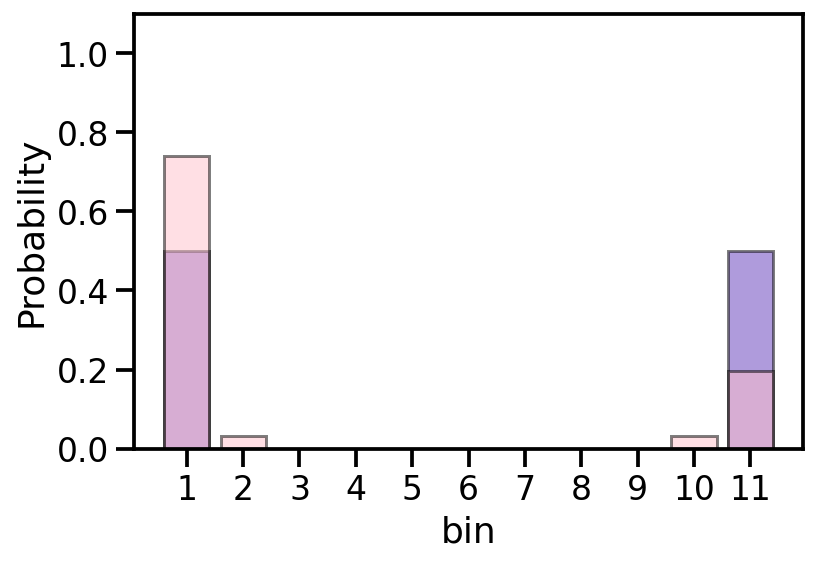

In [72]:
plot_distribution(d1.probs)

y_pred1 = model.predict(x1[0])
plot_distribution(y_pred1[0], color=color2)

1/1 [==============================] - 0s 10ms/step


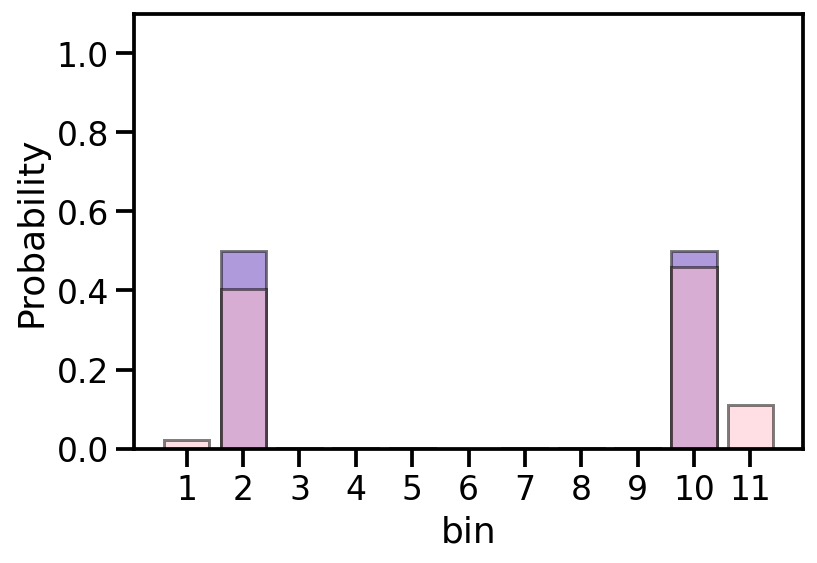

In [73]:
plot_distribution(d2.probs)

y_pred2 = model.predict(x2[0])
plot_distribution(y_pred2[0], color=color2)

1/1 [==============================] - 0s 10ms/step


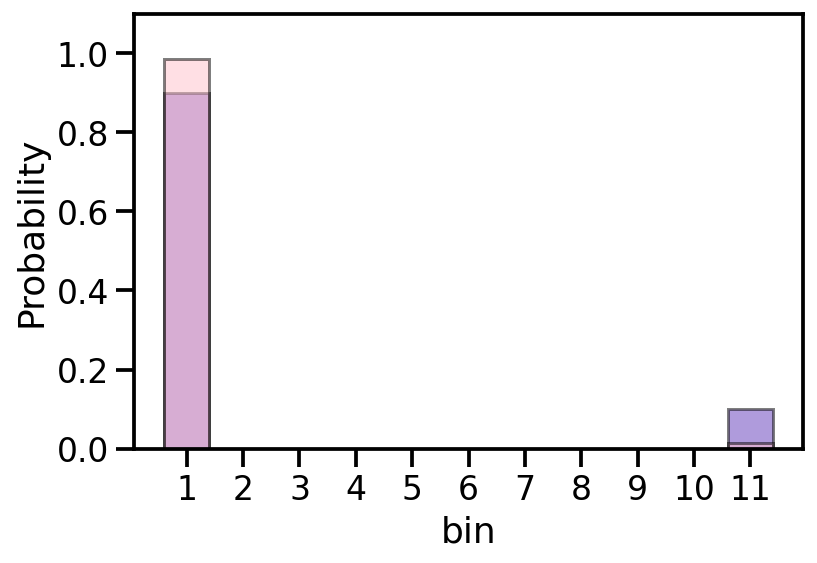

In [74]:
plot_distribution(d3.probs)

y_pred3 = model.predict(x3[0])
plot_distribution(y_pred3[0], color=color2)

1/1 [==============================] - 0s 10ms/step


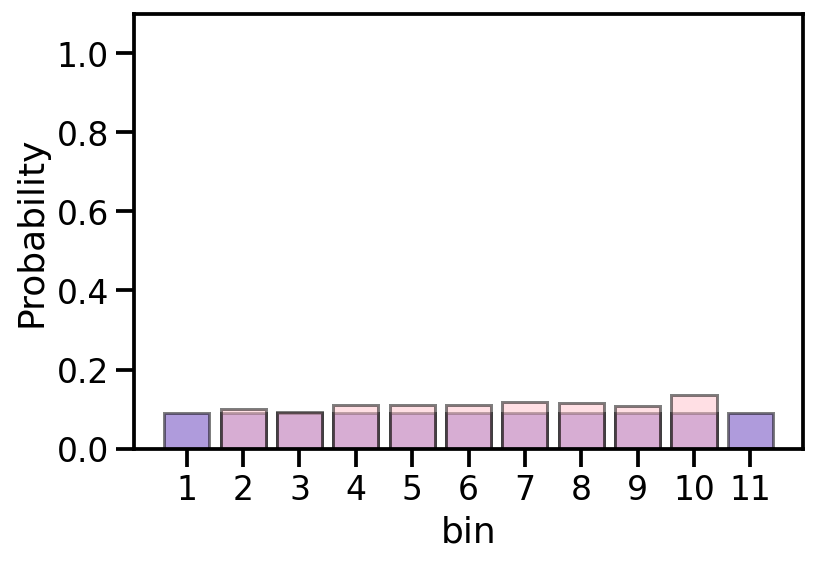

In [75]:
plot_distribution(d4.probs)

y_pred4 = model.predict(x4[0])
plot_distribution(y_pred4[0], color=color2)

# Experiment 3: All WS

In [76]:
def linear_comb_loss(y_true, y_pred):

    alpha = 0
    beta = 1

    return (alpha * ce_loss(y_true, y_pred)) + (beta * wsl(y_true, y_pred))

In [77]:
model = construct_model(loss=linear_comb_loss)

model.fit(
    X, 
    y, 
    epochs=25
)

Epoch 1/25
Tensor("linear_comb_loss/strided_slice:0", shape=(None,), dtype=int64)
Tensor("linear_comb_loss/strided_slice:0", shape=(None,), dtype=int64)
12500/12500 [==============================] - 5s 343us/step - loss: 0.9760 - categorical_crossentropy: 3.0320
Epoch 2/25
12500/12500 [==============================] - 5s 363us/step - loss: 0.9141 - categorical_crossentropy: 5.4840
Epoch 3/25
12500/12500 [==============================] - 4s 344us/step - loss: 0.9131 - categorical_crossentropy: 7.0327
Epoch 4/25
12500/12500 [==============================] - 4s 339us/step - loss: 0.9127 - categorical_crossentropy: 7.7687
Epoch 5/25
12500/12500 [==============================] - 4s 329us/step - loss: 0.9124 - categorical_crossentropy: 8.1663
Epoch 6/25
12500/12500 [==============================] - 4s 318us/step - loss: 0.9119 - categorical_crossentropy: 8.8515
Epoch 7/25
12500/12500 [==============================] - 4s 315us/step - loss: 0.9114 - categorical_crossentropy: 9.3828
Epoc

In [ ]:
plot_distribution(d1.probs)

y_pred1 = model.predict(x1[0])
plot_distribution(y_pred1[0], color=color2)

1/1 [==============================] - 0s 29ms/step


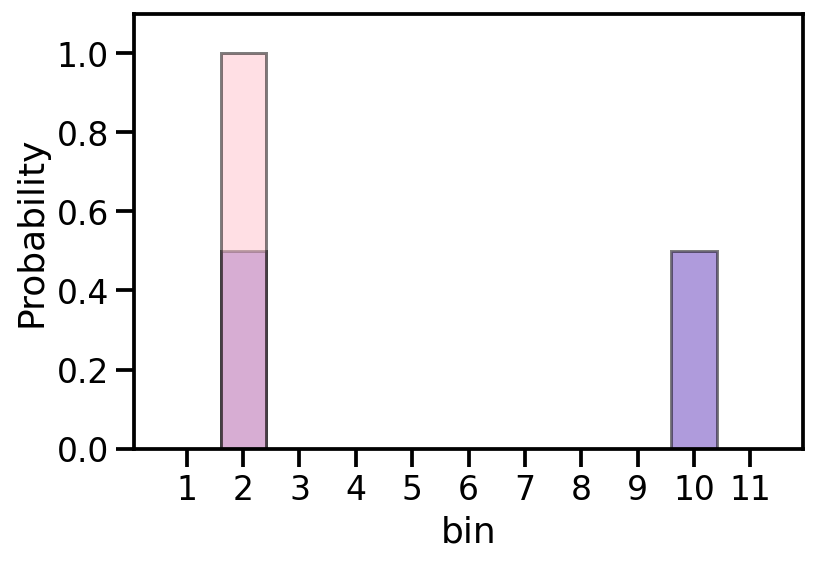

In [78]:
plot_distribution(d2.probs)

y_pred2 = model.predict(x2[0])
plot_distribution(y_pred2[0], color=color2)

1/1 [==============================] - 0s 11ms/step


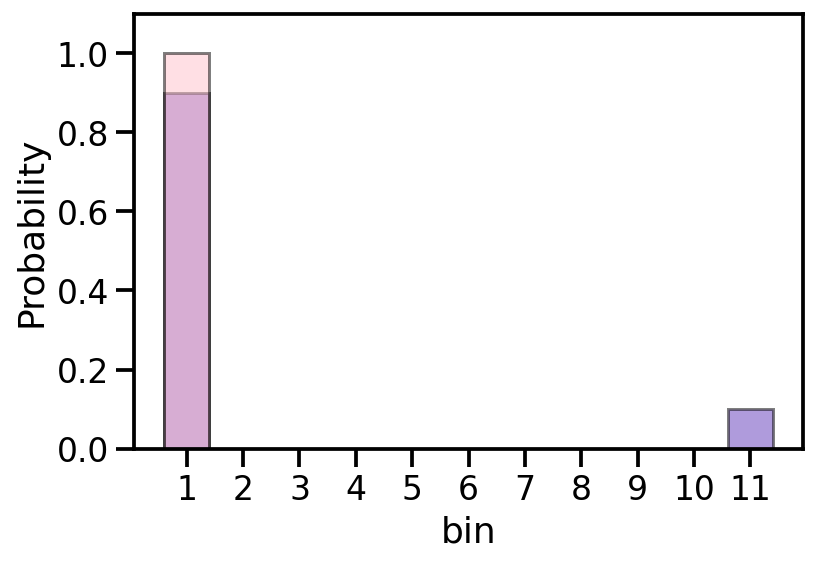

In [79]:
plot_distribution(d3.probs)

y_pred3 = model.predict(x3[0])
plot_distribution(y_pred3[0], color=color2)

1/1 [==============================] - 0s 12ms/step


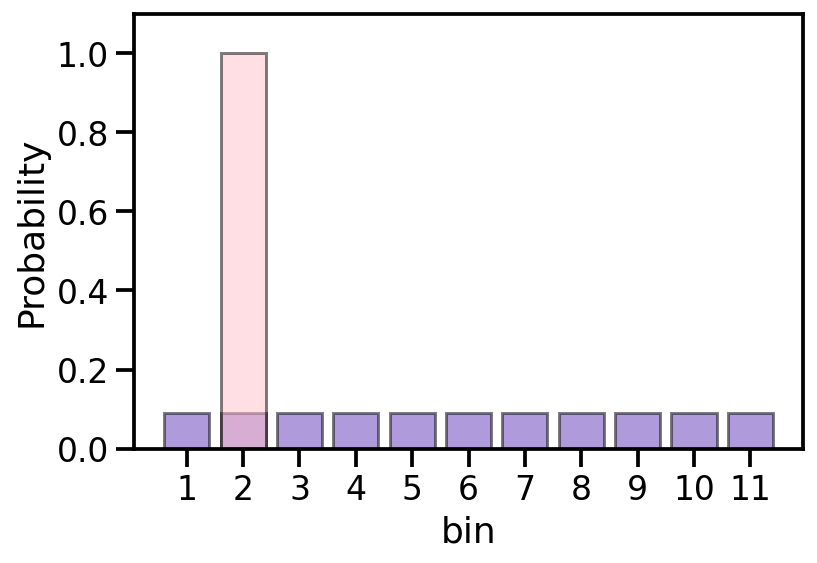

In [80]:
plot_distribution(d4.probs)

y_pred4 = model.predict(x4[0])
plot_distribution(y_pred4[0], color=color2)

# Experiment 4: 50% CE, 50% WS

In [100]:
def linear_comb_loss(y_true, y_pred):

    alpha = 0.4
    beta = 0.6

    return (alpha * ce_loss(y_true, y_pred)) + (beta * wsl(y_true, y_pred))

In [103]:
model = construct_model(loss=linear_comb_loss)

model.fit(
    X, 
    y, 
    epochs=25
)

Epoch 1/25
Tensor("linear_comb_loss/strided_slice:0", shape=(None,), dtype=int64)
Tensor("linear_comb_loss/strided_slice:0", shape=(None,), dtype=int64)
12500/12500 [==============================] - 5s 340us/step - loss: 1.2029 - categorical_crossentropy: 1.4502
Epoch 2/25
12500/12500 [==============================] - 5s 374us/step - loss: 1.1122 - categorical_crossentropy: 1.3311
Epoch 3/25
12500/12500 [==============================] - 4s 353us/step - loss: 1.1015 - categorical_crossentropy: 1.3173
Epoch 4/25
12500/12500 [==============================] - 4s 348us/step - loss: 1.0970 - categorical_crossentropy: 1.3122
Epoch 5/25
12500/12500 [==============================] - 4s 325us/step - loss: 1.0946 - categorical_crossentropy: 1.3096
Epoch 6/25
12500/12500 [==============================] - 4s 324us/step - loss: 1.0932 - categorical_crossentropy: 1.3083
Epoch 7/25
12500/12500 [==============================] - 4s 330us/step - loss: 1.0921 - categorical_crossentropy: 1.3073
Epoc

1/1 [==============================] - 0s 22ms/step


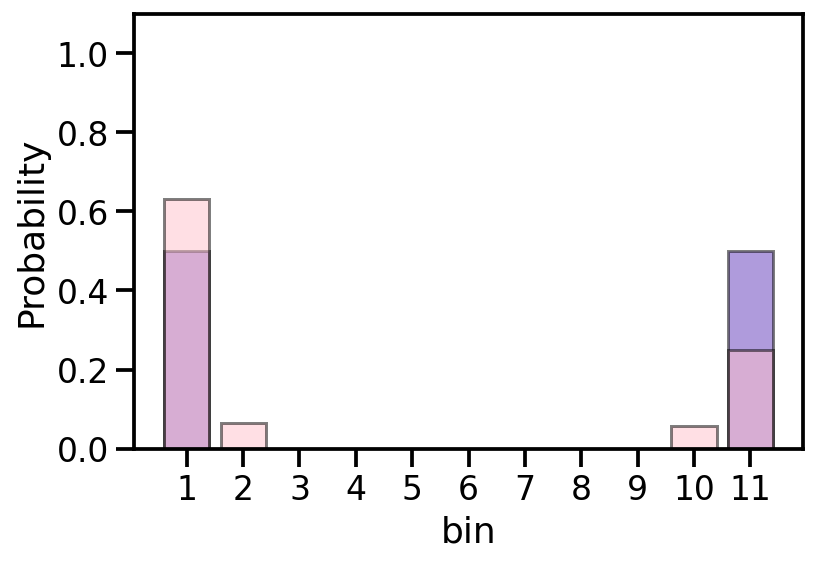

In [104]:
plot_distribution(d1.probs)

y_pred1 = model.predict(x1[0])
plot_distribution(y_pred1[0], color=color2)

1/1 [==============================] - 0s 11ms/step


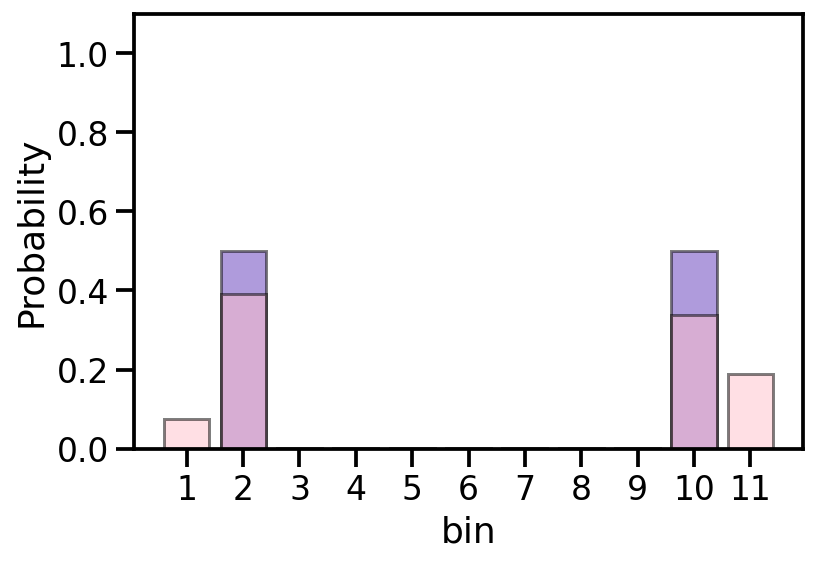

In [105]:
plot_distribution(d2.probs)

y_pred2 = model.predict(x2[0])
plot_distribution(y_pred2[0], color=color2)

1/1 [==============================] - 0s 12ms/step


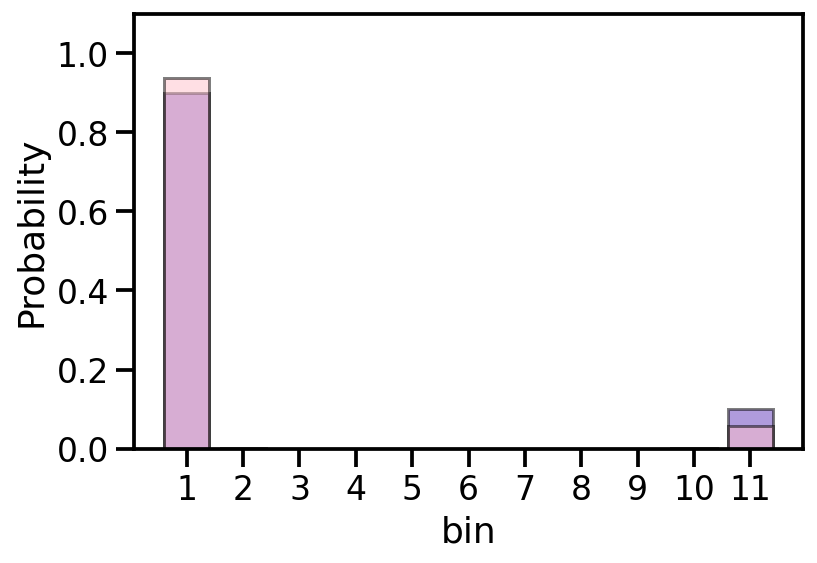

In [106]:
plot_distribution(d3.probs)

y_pred3 = model.predict(x3[0])
plot_distribution(y_pred3[0], color=color2)

1/1 [==============================] - 0s 10ms/step


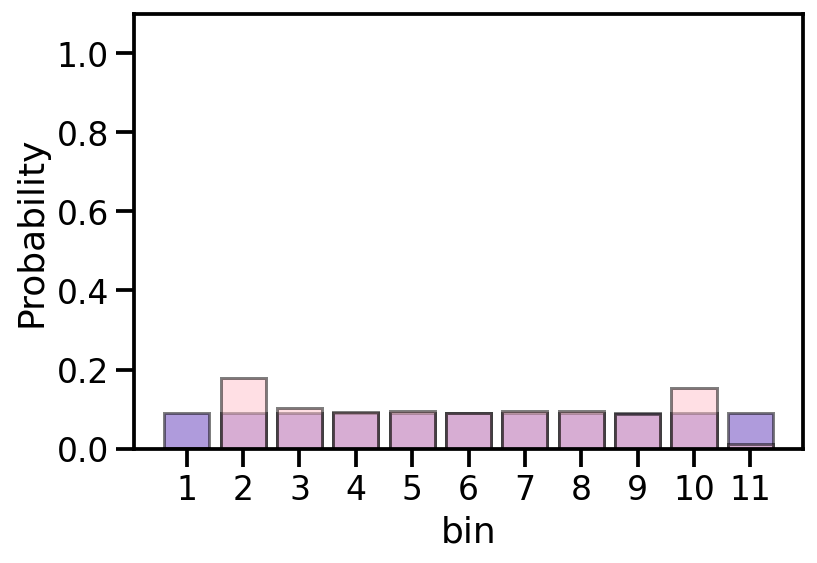

In [107]:
plot_distribution(d4.probs)

y_pred4 = model.predict(x4[0])
plot_distribution(y_pred4[0], color=color2)